In [6]:
import numpy as np
import pandas as pd
import cv2
import glob
import imgaug as ia
from imgaug import augmenters as iaa
from random import *

## Extract frames and apply augmentations
Below we extract frames from a fruitfly videos based on annotation. The generator function will take annotated frames as input, apply various augmentations to generate corresponding images for output. The gaussian for the fruitfly's head and abdomen in the output image undergoes all rotational, translational and scaling transformations but remains unaltered for any noise based transformations. We can subsequently use a vector originating at the fruitfly's abdomen pointing in the direction of its head to get its heading.

In [8]:
video_path = "/home/user/Documents/Vivek/dnn/fruitfly_direction/data/VHS11042018_F2_60/VHS11042018_F2_60.mp4"
data_path = "/home/user/Documents/Vivek/dnn/fruitfly_direction/data/video_VHS11042018_F2_60_annotation_728_0812381800_data.h5"

In [9]:
cap = cv2.VideoCapture(video_path)
data = pd.read_hdf(data_path)

images = np.zeros((0,320,320,3))
test = []
keypoints_on_images = []
head = []
abdomen = []
while(True):
    this = cap.get(1)
    ret, frame = cap.read()
    
    if ret == True:
        if this < 900:
            tmp = cv2.resize(frame, (256, 256), interpolation = cv2.INTER_AREA)
            test.append(tmp)
        
        if this%1800 == 0:
            #print(this)
            frame = cv2.resize(frame, None, fx = 1, fy = 1, interpolation = cv2.INTER_LINEAR)

            keypoints = []
            if this in data['frame_count'].values:
                x1 = data[data['frame_count'] == this]['x'].values[0]
                y1 = data[data['frame_count'] == this]['y'].values[0]
                x2 = data[data['frame_count'] == this]['x'].values[1]
                y2 = data[data['frame_count'] == this]['y'].values[1]

                images = np.concatenate([images,frame[np.newaxis, ...]])
                abdomen.append((x1,y1))
                head.append((x2,y2))
        
    if cv2.waitKey(1) == 27 or ret == False:
        break
            
np.save("/home/user/Documents/Vivek/dnn/fruitfly_direction/output/images2.npy", images)
np.save("/home/user/Documents/Vivek/dnn/fruitfly_direction/output/test2.npy", test)
del test[:]

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

/usr/lib/python3/dist-packages/tables/path.py:118: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  % (name, _warnInfo), NaturalNameWarning)


-1

In [10]:
keypoints1 = []
keypoints2 = []
for i in range(0,len(head)):
    keypoints1.append(ia.KeypointsOnImage([ia.Keypoint(x=head[i][0], y=head[i][1])], shape=images[i].shape))
    keypoints2.append(ia.KeypointsOnImage([ia.Keypoint(x=abdomen[i][0], y=abdomen[i][1])], shape=images[i].shape))

In [11]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale=(0.8, 1.2),
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

In [12]:
def generate_batch(images, keypoints):
    idx = randint(0,len(images)-1)

    seq_det = seq.to_deterministic()
    image_aug = seq_det.augment_images([images[idx]])[0]
    keypoints_aug1 = seq_det.augment_keypoints([keypoints1[idx]])[0]
    keypoints_aug2 = seq_det.augment_keypoints([keypoints2[idx]])[0]
    
    img_augr = np.zeros((256, 256, image_aug.shape[2]), dtype=np.uint8)
    out1 = np.zeros((images[idx].shape[0], images[idx].shape[1], 1))
    out_aug1 = np.zeros((image_aug.shape[0], image_aug.shape[1]))
    out_augr1 = np.zeros((256, 256))
    out2 = np.zeros((images[idx].shape[0], images[idx].shape[1], 1))
    out_aug2 = np.zeros((image_aug.shape[0], image_aug.shape[1]))
    out_augr2 = np.zeros((256, 256))
    
    cv2.circle(out1, (int(keypoints1[idx].keypoints[0].x), int(keypoints1[idx].keypoints[0].y)), 3, 255, -1)
    cv2.GaussianBlur(out1, (21,21), 5, out1)
    cv2.circle(out_aug1, (int(keypoints_aug1.keypoints[0].x), int(keypoints_aug1.keypoints[0].y)), 3, 255, -1)
    cv2.GaussianBlur(out_aug1, (21,21), 5, out_aug1)
    cv2.circle(out2, (int(keypoints2[idx].keypoints[0].x), int(keypoints2[idx].keypoints[0].y)), 3, 255, -1)
    cv2.GaussianBlur(out2, (21,21), 5, out2)
    cv2.circle(out_aug2, (int(keypoints_aug2.keypoints[0].x), int(keypoints_aug2.keypoints[0].y)), 3, 255, -1)
    cv2.GaussianBlur(out_aug2, (21,21), 5, out_aug2)

    imgr = cv2.resize(images[idx], (256, 256), interpolation = cv2.INTER_AREA)
    img_augr = cv2.resize(image_aug, (256, 256), interpolation = cv2.INTER_AREA)
    outr1 = cv2.resize(out1, (256, 256), interpolation = cv2.INTER_AREA)
    out_augr1 = cv2.resize(out_aug1, (256, 256), interpolation = cv2.INTER_AREA)
    outr2 = cv2.resize(out2, (256, 256), interpolation = cv2.INTER_AREA)
    out_augr2 = cv2.resize(out_aug2, (256, 256), interpolation = cv2.INTER_AREA)
    
    outr = np.stack((outr1, outr2), axis=-1)
    out_augr = np.stack((out_augr1, out_augr2), axis=-1)
    
    return imgr[np.newaxis, ...], outr[np.newaxis, ...], img_augr[np.newaxis, ...], out_augr[np.newaxis, ...]

In [13]:
imgr, outr, img_augr, out_augr = generate_batch(images, keypoints)
imgr.shape, outr.shape, img_augr.shape, out_augr.shape

((1, 256, 256, 3), (1, 256, 256, 2), (1, 256, 256, 3), (1, 256, 256, 2))

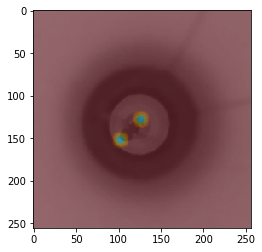

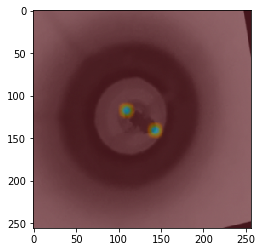

In [15]:
import matplotlib.pyplot as plt
outr_norm = cv2.normalize(np.squeeze(outr), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
outr_norm = outr_norm[..., 0] + outr_norm[..., 1]
outr_cm = cv2.applyColorMap(outr_norm, cv2.COLORMAP_PARULA)
testr = cv2.addWeighted(np.squeeze(imgr).astype('uint8'), 0.5, outr_cm, 0.5, 1)
plt.imshow(testr)
plt.show()


out_augr_norm = cv2.normalize(np.squeeze(out_augr), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
out_augr_norm = out_augr_norm[..., 0] + out_augr_norm[..., 1]
out_augr_cm = cv2.applyColorMap(out_augr_norm, cv2.COLORMAP_PARULA)
test_augr = cv2.addWeighted(np.squeeze(img_augr).astype('uint8'), 0.5, out_augr_cm, 0.5, 1)
plt.imshow(test_augr)
plt.show()

In [59]:
def generator():
    while(True):
        image, out, img_augr, out_augr = generate_batch(images, keypoints)
    
        yield (img_augr,out_augr)

## Stacked hourglass model
This model combines bottom-up (conv and pooling) with top-down (upsampling and deconv) to use features at multiple scales for final classification of features in the image. In this case, we use it to detect the head and the arse i.e. direction of a fruit fly.

In [60]:
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D, Add
from keras.models import Model
from keras.optimizers import RMSprop

In [61]:
def conv_pool(conv_in, nfilters):
    conv = Conv2D(filters=nfilters, kernel_size=(3,3), padding='same', activation='selu')(conv_in)
    pool = AveragePooling2D(pool_size=(2,2))(conv)
    return conv, pool

def upsample_add_deconv(upsamp_in, res, nfilters):
    upsample = UpSampling2D(size=(2,2))(upsamp_in) #nxnx512
    add = Add()([res,upsample]) #nxnx512
    deconv = Conv2D(filters=nfilters, kernel_size=(3,3), padding='same', activation='selu')(add)
    return upsample, add, deconv

In [62]:
input_layer = Input(batch_shape=(None, None, None, 3)) #8nx8nx3

# The conv-pool-upsample-deconv sequence here creates and hourglass-like network with a bottleneck in the middle
# This by itself however only uses large-scale f+eatures for feature detection
# To use features at multiple scales, we add the residuals from conv layers to the upsampled layers

# --------------------------------- bottom-up part of the hourglass --------------------------------- #
conv1, pool1 = conv_pool(input_layer, 8)
conv2, pool2 = conv_pool(pool1, 16)
conv3, pool3 = conv_pool(pool2, 32)
conv4 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='selu')(pool3)
# --------------------------------- xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx --------------------------------- #

# ------------- modify conv layer output to match shape to corresponding upsample layer ------------- #
res3 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='selu')(conv3)
res2 = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='selu')(conv2)
res1 = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='selu')(conv1)
# --------------------------------- xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx --------------------------------- #

# --------------------------------- top-down part of the hourglass ---------------------------------- #
upsample3, add3, deconv3 = upsample_add_deconv(conv4, res3, 32)
upsample2, add2, deconv2 = upsample_add_deconv(deconv3, res2, 16)
upsample1, add1, deconv1 = upsample_add_deconv(deconv2, res1, 8)
# --------------------------------- xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx --------------------------------- #

output_layer = Conv2D(filters=2, kernel_size=(3,3), padding='same', activation='selu')(deconv1) #nxnx2 (for each detection class)

model = Model(input_layer, output_layer)
model.compile(RMSprop(lr=2e-4), loss='mse')

In [63]:
model.fit_generator(generator(), 1000, 10, workers=4, use_multiprocessing=True)

/home/user/.local/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
1000/1000 [==============================] - 12s 12ms/step - loss: 2.4481
Epoch 2/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.3269
Epoch 3/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2306
Epoch 4/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2061
Epoch 5/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1893
Epoch 6/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1845
Epoch 7/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1770
Epoch 8/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1639
Epoch 9/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1635
Epoch 10/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1535


## Run predictions
Here, we run predictions for the hummingbird video to check for performance of the trained model. We first pad the input to match the training image size and then run it through the model for predictions

In [64]:
test = np.load("/home/user/Documents/Vivek/dnn/fruitfly_direction/output/test2.npy")
test.shape

(900, 256, 256, 3)

In [76]:
predictions = model.predict(test, batch_size=1)
predictions.shape

(900, 256, 256, 2)

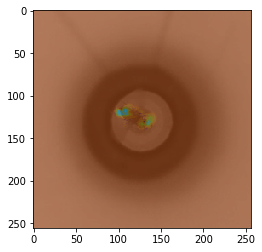

In [77]:
preds = (predictions[5][..., 0] + predictions[5][..., 1])
preds = cv2.normalize(preds, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
pred_cm = cv2.applyColorMap(preds, cv2.COLORMAP_PARULA)
pred = cv2.addWeighted(np.squeeze(test[5]).astype('uint8'), 0.5, pred_cm, 0.5, 1)
plt.imshow(pred)

In [80]:
cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter(filename = 'VHS11042018_F2_60.mp4', fourcc = fourcc, fps = 90.0, frameSize = (256, 256), isColor = True)

while(True):
    this = cap.get(1)
    ret, frame = cap.read()
    
    if ret == True and frame.shape[0] > 0 and this < test.shape[0]:
        frame = cv2.resize(frame, (256, 256), interpolation = cv2.INTER_AREA)
        
        x1 = np.where(predictions[int(this)][...,0] == np.max(predictions[int(this)][...,0]))[1][0]
        y1 = np.where(predictions[int(this)][...,0] == np.max(predictions[int(this)][...,0]))[0][0]
        x2 = np.where(predictions[int(this)][...,1] == np.max(predictions[int(this)][...,1]))[1][0]
        y2 = np.where(predictions[int(this)][...,1] == np.max(predictions[int(this)][...,1]))[0][0]
        #cv2.circle(frame, (x1,y1), 5, (0,0,255), 2)
        #cv2.circle(frame, (x2,y2), 5, (0,255,255), 2)
        cv2.arrowedLine(frame, (x2,y2), (x1,y1), (0,0,255), 2, tipLength=0.2)
        
        
        out.write(frame)
        cv2.imshow('tracked', frame)

    if cv2.waitKey(1) == 27 or ret == False or this > test.shape[0]:
        break
            
# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

KeyboardInterrupt: 